# Can Wholesale Electricity Prices Be Predicted Using A SARIMA Model?

## Extract the data

In [507]:
# Import all of the neccessary libraries for our project.
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from math import sqrt
from tabulate import tabulate
import matplotlib.pyplot as plt

# Load the data from our csv file, limiting the range to the first 6 years.
df = pd.read_csv('NLMonthlyDA.csv').iloc[:-44]
# Ensure correct date formatting.
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)

# Display the data to ensure that the extraction had the intended effect.
df


,DAPrice
Date,
2015-01-01,41.0940
2015-02-01,46.3782
2015-03-01,42.2060
2015-04-01,41.3642
2015-05-01,37.3790
...,...
2020-08-01,34.0243
2020-09-01,42.6225
2020-10-01,37.1132


## Data Exploration

### Visual Investigation

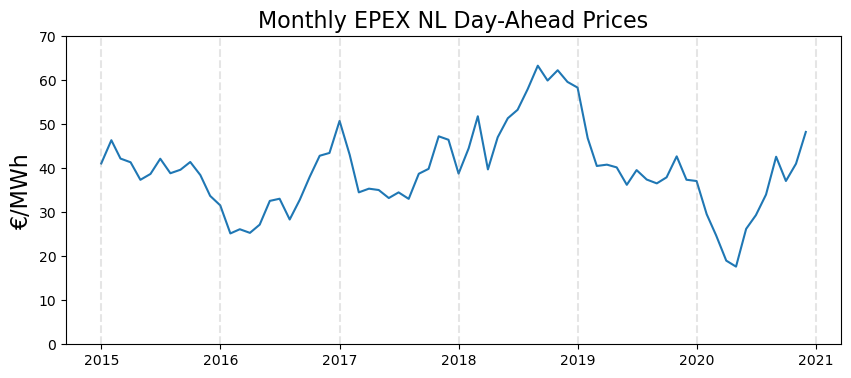

In [508]:
# Plot the data to visually inspect it.
plt.figure(figsize=(10,4))
plt.plot(df['DAPrice'])
plt.title('Monthly EPEX NL Day-Ahead Prices', fontsize=16)
plt.ylabel('€/MWh', fontsize=16)
plt.ylim(0, 70)
# Add vertical lines at yearly intervals to assist in spotting seasonal patterns.
for year in range(2015,2022):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='grey', linestyle='--', alpha=0.2)

### Seasonal Decomposition

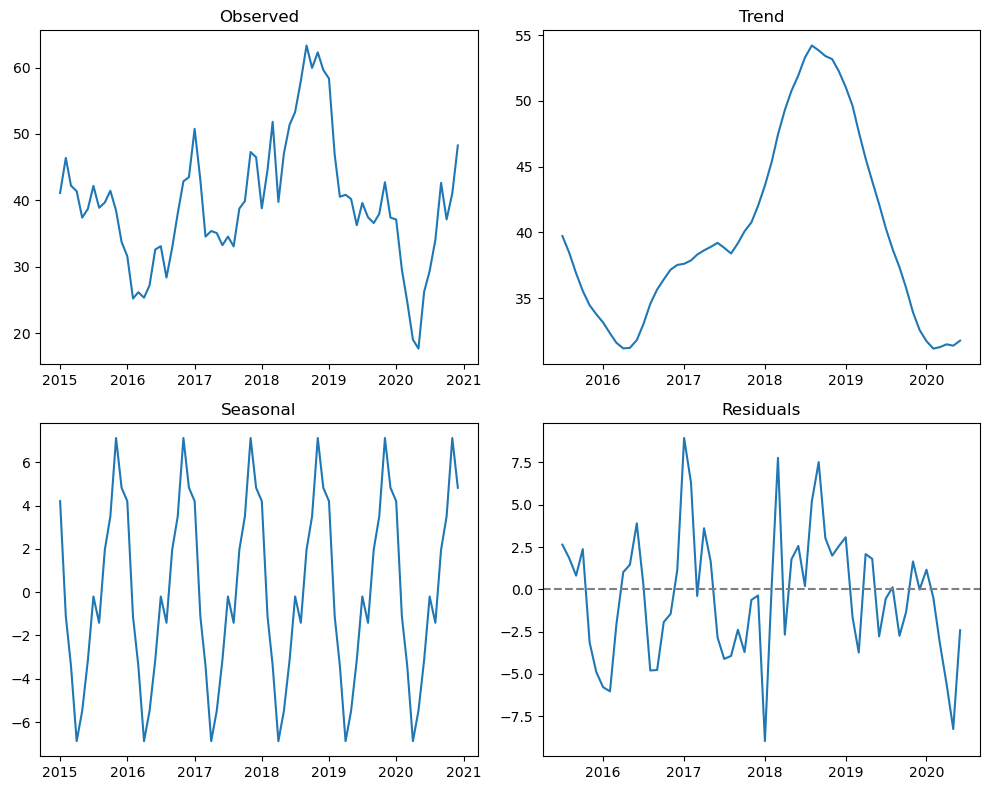

The mean of the residuals is -0.31


In [509]:
# Use the statsmodels seaonal decomposition function to decompose and plot the characteristics of the data.
decomp = seasonal_decompose(df['DAPrice'], model='additive', period=12)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Plot data on each subplot
axes[0, 0].plot(decomp.observed)
axes[0, 0].set_title('Observed')

axes[0, 1].plot(decomp.trend)
axes[0, 1].set_title('Trend')

axes[1, 0].plot(decomp.seasonal)
axes[1, 0].set_title('Seasonal')

axes[1, 1].plot(decomp.resid)
axes[1, 1].set_title('Residuals')
axes[1, 1].axhline(0, color='grey', linewidth=1.5, linestyle='--')

# Adjust the layout of the plots.
plt.tight_layout()

# Display the plots.
plt.show()

print("The mean of the residuals is", round(decomp.resid.mean(),2))

### Test for Stationarity: Augmented Dickey-Fuller

In [510]:
# Define a function which performs an Augmented Dickey-Fuller Test and returns the key results.

def adf_test(series):
    '''
    Perform the Augmented Dickey-Fuller (ADF) test on time-series data and print the results of this.

    This function tests for stationarity in time-series data by performing the ADF test.
    The Akaike Information Criterion (AIC) method is used for automatic lag selection.

    Inputs:
    -----------
    series : array-like
        The time series data for which we will test stationarity.

    Outputs:
    --------
    - ADF Statistic: The ADF test statistic.
    - p-value: The p-value of the test.
    - Critical Values: The critical values for different confidence levels.
        All of the above are printed.

    Note:
    ------
    The ADF test null hypothesis is that the time-series is non-stationary.
    A small p-value (< 0.05) indicates strong evidence to reject the null hypothesis.
    If p is indeed small, we can conclude that the time-series is stationary.'''
    
    test_results = adfuller(series, autolag='AIC')
    print('ADF Statistic:', test_results[0])
    print('p-value:', test_results[1])
    print('Critical Values:')
    for key, value in test_results[4].items():
        print(f'   {key}: {value}')
        
# Run the ADF test on our raw data.
adf_test(df['DAPrice'])

ADF Statistic: -2.0995929305493366
p-value: 0.24467831767753023
Critical Values:
   1%: -3.542412746661615
   5%: -2.910236235808284
   10%: -2.5927445767266866


In [511]:
# Take the seasonal difference of the raw data.
df['DAPrice_sdiff'] = df['DAPrice'].diff(periods=12)

# Remove any null values.
df_sdiff = df['DAPrice_sdiff'].dropna()

# Run the ADF test on the data following seasonal differencing.
print(adf_test(df_sdiff))

ADF Statistic: -1.9872712365958038
p-value: 0.29218195525970847
Critical Values:
   1%: -3.5745892596209488
   5%: -2.9239543084490744
   10%: -2.6000391840277777
None


In [512]:
# Take the standard difference of our seasonally differenced data.
df['DAPrice_fdiff'] = df_sdiff.diff()

# Remove any null values.
df_fdiff = df['DAPrice_fdiff'].dropna()

# Run the ADF test on the data following both seasonal and standard differencing.
adf_test(df_fdiff)

ADF Statistic: -3.7983436068047745
p-value: 0.0029243075993647936
Critical Values:
   1%: -3.5778480370438146
   5%: -2.925338105429433
   10%: -2.6007735310095064


## Fitting The Model

### Setting the Parameters

Text(0.5, 1.0, 'Autocorrelation')

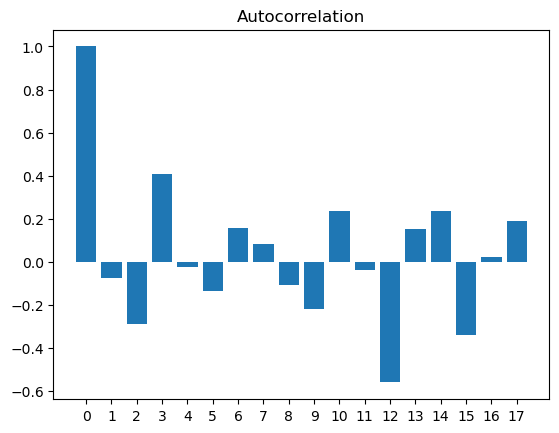

In [513]:
# Run the ACF (AutoCorrelation Function) on the stationary data and plot the results.
acf_values = acf(df_fdiff)
num_lags = 18
plt.bar(range(num_lags), acf_values[:num_lags])
plt.xticks(range(0,num_lags))
plt.title('Autocorrelation')


Text(0.5, 1.0, 'Partial Autocorrelation')

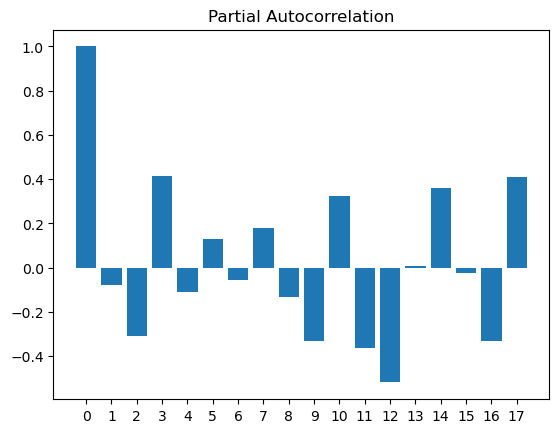

In [514]:
# Run the PACF (Partial AutoCorrelation Function) on the stationary data and plot the results.
pacf_values = pacf(df_fdiff)
num_lags = 18
plt.bar(range(num_lags), pacf_values[:num_lags])
plt.xticks(range(0,num_lags))
plt.title('Partial Autocorrelation')

### Train the Model

In [515]:
# Specify the training and test data sets.
train_start = datetime(2015,1,1)
train_end = datetime(2019,12,1)
test_end = datetime(2020,12,1)

train_data = df[train_start:train_end].iloc[:,0]
test_data = df[train_end+relativedelta(months=1):test_end].iloc[:,0]

In [516]:
# Define the non_seasonal and seasonal parameters.
non_seasonal = (1,1,1)
seasonal = (0, 1, 1, 12)

# Define the model as the SARIMA with the above specified parameters.
model = SARIMAX(train_data, order=non_seasonal, seasonal_order=seasonal)

C:\Users\Jake.Wernham\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Jake.Wernham\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [517]:
#Fit the model and print the summary of the results.
model_fit = model.fit()
print(model_fit.summary())


C:\Users\Jake.Wernham\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Jake.Wernham\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Jake.Wernham\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                     SARIMAX Results                                      
Dep. Variable:                            DAPrice   No. Observations:                   60
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -147.558
Date:                            Wed, 25 Sep 2024   AIC                            303.116
Time:                                    16:31:39   BIC                            310.517
Sample:                                01-01-2015   HQIC                           305.901
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1517      1.069      0.142      0.887      -1.943       2.247
ma.L1         -0.2788      1.045   

### Produce Forecasts and Metrics

Text(0, 0.5, 'Error')

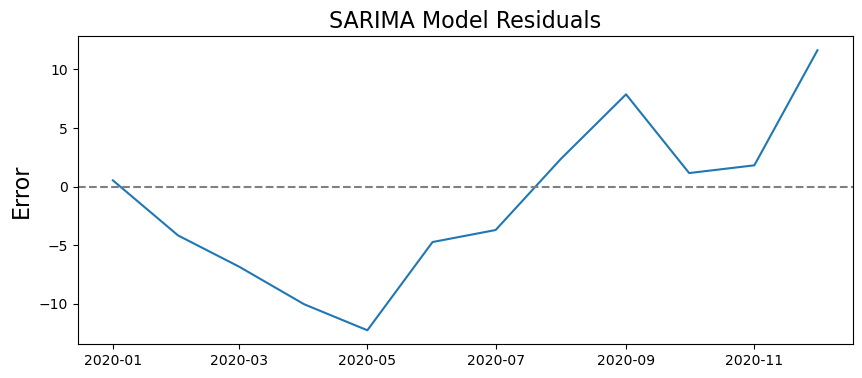

In [518]:
#Create predictions from the test data, calculate the residuals, and plot them.
forecast = model_fit.forecast(len(test_data))
forecast = pd.Series(predictions, index=test_data.index)
residuals = test_data - forecast
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='grey')
plt.title('SARIMA Model Residuals', fontsize=16)
plt.ylabel('Error', fontsize=16)

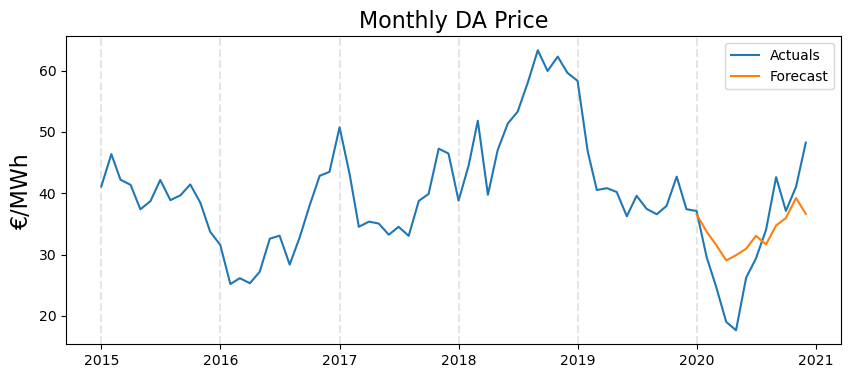

In [519]:
# Plot the forecast values on top of the actuals (train and test data).
plt.figure(figsize=(10,4))
plt.plot(df['DAPrice'])
plt.plot(forecast)
plt.legend(('Actuals', 'Forecast'), fontsize=10)
plt.title('Monthly DA Price', fontsize=16)
plt.ylabel('€/MWh', fontsize=16)
for year in range(2015,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='grey', linestyle='--', alpha=0.2)

In [520]:
# Calculate the key performance metrics of the forecast.
print('MAPE:', round(np.mean(abs(residuals/test_data)),4))
print('RMSE:', round(np.sqrt(np.mean(residuals**2)),4))

MAPE: 0.2108
RMSE: 6.82


## Refining The Model

### Introducting the Rolling Forecast

In [521]:
# Implement the rolling forecast approach.
rolling_forecast = test_data.copy()
for train_end in test_data.index:
    train_data = df[:train_end-relativedelta(months=1)].iloc[:,0]
    model = SARIMAX(train_data, order=non_seasonal, seasonal_order=seasonal)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_forecast[train_end] = pred
    

C:\Users\Jake.Wernham\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Jake.Wernham\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Jake.Wernham\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Jake.Wernham\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Jake.Wernh

C:\Users\Jake.Wernham\AppData\Local\Temp\ipykernel_7716\4151641059.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_forecast[train_end] = pred
C:\Users\Jake.Wernham\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Jake.Wernham\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Jake.Wernham\AppData\Local\Temp\ipykernel_7716\4151641059.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_forecast[train_end] = pred
C:\Users\Jake.Wernham\AppData\Local\anac

Text(0, 0.5, 'Error')

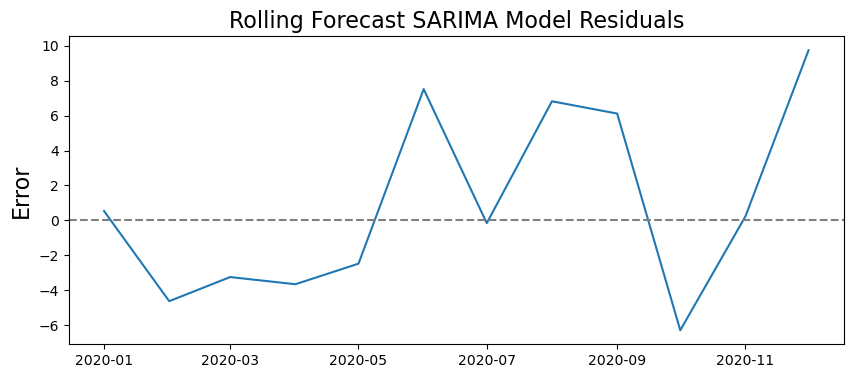

In [522]:
# Calculate the residuals of the rolling forecast data and plot them.
rolling_residuals = test_data - rolling_forecast
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='grey')
plt.title('Rolling Forecast SARIMA Model Residuals', fontsize=16)
plt.ylabel('Error', fontsize=16)

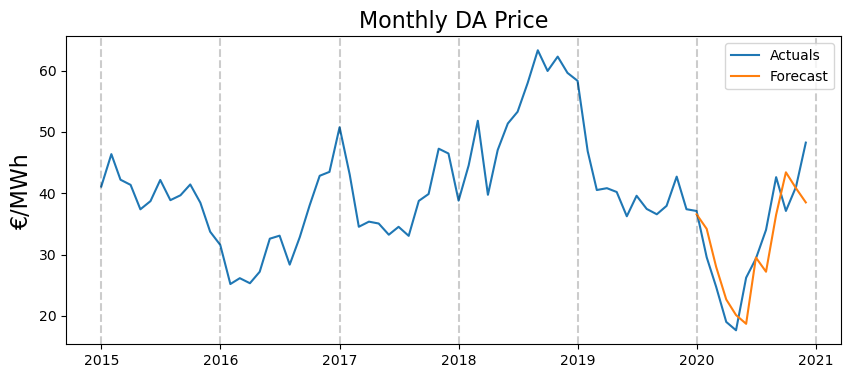

In [523]:
# Plot the rolling forecast values along with the actuals data.
plt.figure(figsize=(10,4))

plt.plot(df['DAPrice'])
plt.plot(rolling_predictions)

plt.legend(('Actuals', 'Forecast'), fontsize=10)

plt.title('Monthly DA Price', fontsize=16)
plt.ylabel('€/MWh', fontsize=16)
for year in range(2015,2022):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [524]:
# Calculate the key performance metrics of the forecast.
print('MAPE:', round(np.mean(abs(rolling_residuals/test_data)),4))
print('RMSE:', round(np.sqrt(np.mean(rolling_residuals**2)),4))

MAPE: 0.1375
RMSE: 5.2236
